In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.regularizers import l1,l2
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# load the dataset
(xtrain, _), (xtest, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true # K.flatten(y_true)
    y_pred_f = y_pred # K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [0]:
xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.

xtrain_red = xtrain[:,:,:,0]
xtrain_green = xtrain[:,:,:,1] 
xtrain_blue = xtrain[:,:,:,2]

xtest_red = xtest[:,:,:,0]
xtest_green = xtest[:,:,:,1] 
xtest_blue = xtest[:,:,:,2]

xtrain_red = xtrain_red.reshape(len(xtrain_red), np.prod(xtrain_red.shape[1:]))
xtrain_green = xtrain_green.reshape(len(xtrain_green), np.prod(xtrain_green.shape[1:]))
xtrain_blue = xtrain_blue.reshape(len(xtrain_blue), np.prod(xtrain_blue.shape[1:]))

xtest_red = xtest_red.reshape(len(xtest_red), np.prod(xtest_red.shape[1:]))
xtest_green = xtest_green.reshape(len(xtest_green), np.prod(xtest_green.shape[1:]))
xtest_blue = xtest_blue.reshape(len(xtest_blue), np.prod(xtest_blue.shape[1:]))


train_dset = []
train_dset.extend(xtrain_red)
train_dset.extend(xtrain_green)
train_dset.extend(xtrain_blue)
dset_train = np.asarray(train_dset)

test_dset = []
test_dset.extend(xtest_red)
test_dset.extend(xtest_green)
test_dset.extend(xtest_blue)
dset_test = np.asarray(test_dset)

In [0]:
input_layer = xtrain_red.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(dset_train.shape)
print(dset_test.shape)

(150000, 1024)
(30000, 1024)


In [0]:
input_img = Input(shape=(input_layer,))

W0815 13:37:46.010035 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 13:37:46.054491 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
# network architecture
# vanilla autoencoder with fully-connected layer
# ENCODER
x = Dense(units = hid_layer1, activation='relu')(input_img)
x = Dense(units = hid_layer2, activation='relu')(x)
x = Dense(units = hid_layer3, activation='relu')(x)

encoded = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(x)

# DECODER
x = Dense(units = hid_layer5, activation = 'relu')(encoded)
x = Dense(units = hid_layer6, activation='relu')(x)
x = Dense(units = hid_layer7, activation='relu')(x)

decoded = Dense(units = output_layer, activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# autoencoder.compile(optimizer= Adam(lr=1e-5), loss='mean_absolute_error')
autoencoder.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

W0815 13:37:46.079079 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 13:37:46.244431 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 576)               590400    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               147712    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
__________

In [0]:
# train the model
history = autoencoder.fit(dset_train, dset_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(dset_test, dset_test))

W0815 13:37:46.507029 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0815 13:37:46.761987 140661537384320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 150000 samples, validate on 30000 samples
Epoch 1/100
150000/150000 [==============================] - 17s 116us/step - loss: 0.3827 - dice_coef: 0.6178 - val_loss: 0.3546 - val_dice_coef: 0.6458
Epoch 2/100
150000/150000 [==============================] - 13s 85us/step - loss: 0.3550 - dice_coef: 0.6455 - val_loss: 0.3479 - val_dice_coef: 0.6525
Epoch 3/100
150000/150000 [==============================] - 13s 85us/step - loss: 0.3496 - dice_coef: 0.6508 - val_loss: 0.3468 - val_dice_coef: 0.6536
Epoch 4/100
150000/150000 [==============================] - 13s 85us/step - loss: 0.3486 - dice_coef: 0.6518 - val_loss: 0.3458 - val_dice_coef: 0.6546
Epoch 5/100
150000/150000 [==============================] - 13s 85us/step - loss: 0.3471 - dice_coef: 0.6533 - val_loss: 0.3439 - val_dice_coef: 0.6565
Epoch 6/100
150000/150000 [==============================] - 13s 85us/step - loss: 0.3417 - dice_coef: 0.6586 - val_loss: 0.3366 - val_dice_coef: 0.6637
Epoch 7/100
150000/150000 [===

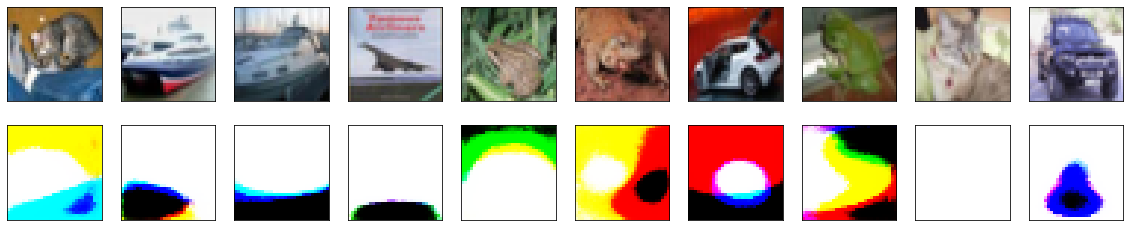

In [0]:
# show the result at the decoder output
decoded_imgs_red = autoencoder.predict(xtest_red)
decoded_imgs_green = autoencoder.predict(xtest_green)
decoded_imgs_blue = autoencoder.predict(xtest_blue)

n = 10
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[i].reshape(32, 32)

    plt.imshow(test_imgs)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[i].reshape(32, 32)

    plt.imshow(dec_imgs)
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

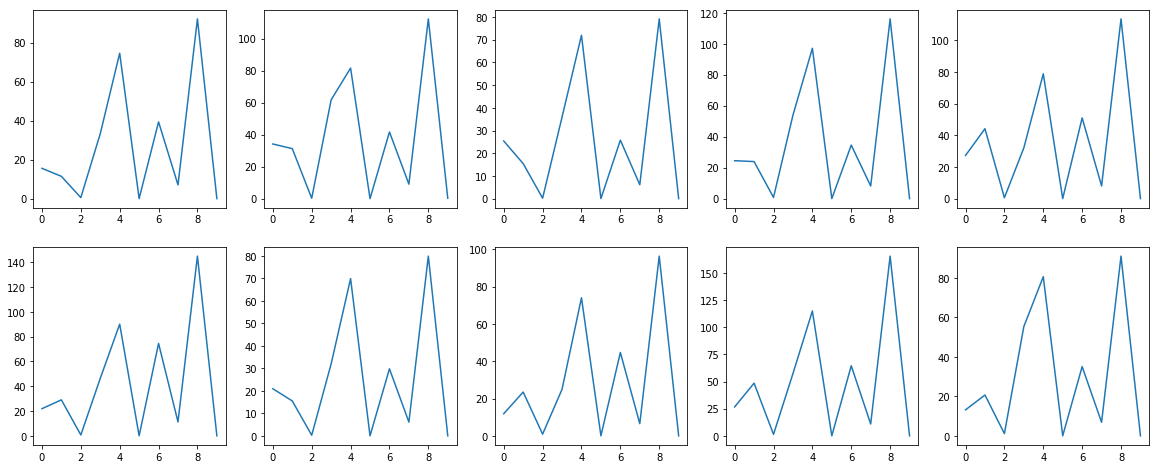

In [0]:
# show the representation at the bottleneck
encoded_imgs_red = encoder.predict(xtest_red)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_red[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

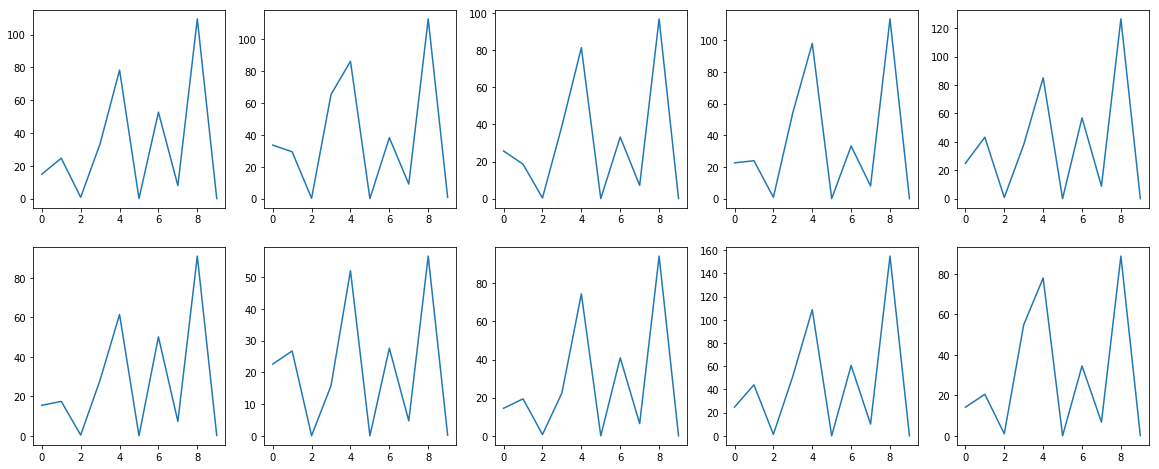

In [0]:
# show the representation at the bottleneck
encoded_imgs_green = encoder.predict(xtest_green)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_green[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

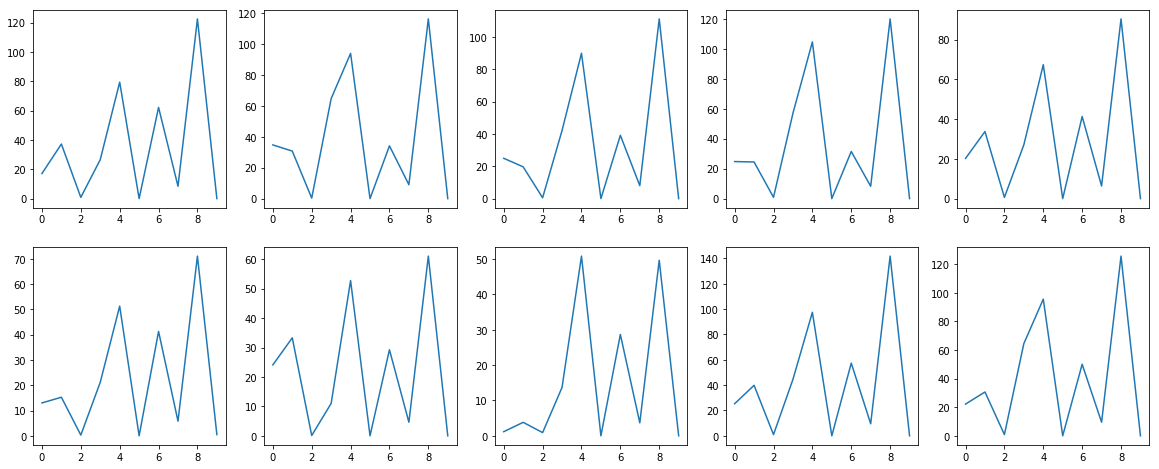

In [0]:
# show the representation at the bottleneck
encoded_imgs_blue = encoder.predict(xtest_blue)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_blue[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

(array([364., 175., 101.,  83.,  97., 105.,  48.,  32.,  14.,   5.]),
 array([0.        , 0.09803832, 0.19607665, 0.29411498, 0.3921533 ,
        0.4901916 , 0.58822995, 0.68626827, 0.7843066 , 0.8823449 ,
        0.9803832 ], dtype=float32),
 <a list of 10 Patch objects>)

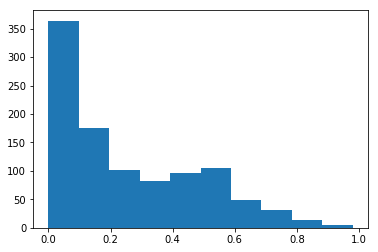

In [0]:
err_red = np.sqrt(np.square(xtest_red[1] - decoded_imgs_red[1]))
plt.hist(err_red)

(array([417., 165., 118.,  80., 103.,  84.,  28.,  18.,   7.,   4.]),
 array([0.        , 0.09803922, 0.19607843, 0.29411766, 0.39215687,
        0.49019608, 0.5882353 , 0.6862745 , 0.78431374, 0.88235295,
        0.98039216], dtype=float32),
 <a list of 10 Patch objects>)

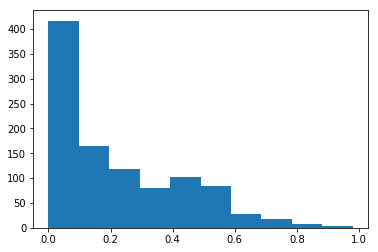

In [0]:
err_green = np.sqrt(np.square(xtest_green[1] - decoded_imgs_green[1]))
plt.hist(err_green)

(array([415., 152., 116.,  84., 100.,  81.,  35.,  27.,   8.,   6.]),
 array([0.        , 0.09058823, 0.18117647, 0.2717647 , 0.36235294,
        0.45294118, 0.5435294 , 0.63411766, 0.7247059 , 0.81529415,
        0.90588236], dtype=float32),
 <a list of 10 Patch objects>)

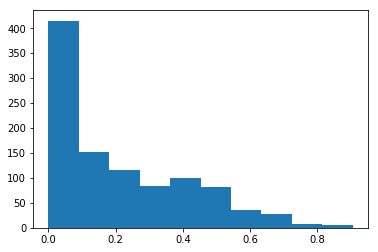

In [0]:
err_blue = np.sqrt(np.square(xtest_blue[1] - decoded_imgs_blue[1]))
plt.hist(err_blue)

In [0]:
autoencoder.save('autoencoder_baseline_dice.h5')